##### Importing required packages and libraries 

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

import itertools
import pandas as pd
import numpy as np
import warnings
from scipy.sparse import csr_matrix 

#python libraries for visualization

#plotly
import plotly
import plotly.graph_objects as go
#networkx
import networkx as nx
from networkx.algorithms import community
import holoviews as hv
from holoviews import opts
#bokeh for plotting
import bokeh.plotting
from bokeh.plotting import from_networkx, figure
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
from bokeh.io import output_notebook, save, show, reset_output
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8, Spectral11, Category20_15, Category20_20, Turbo256
from bokeh.transform import linear_cmap

##### Loading .mat files - respPeak = peak of ind, allROIPositions

In [2]:
mat_load = sio.loadmat('C:/Users/m.nedeljkovic/Desktop/respPeak.mat')['x']
roi_load = sio.loadmat('C:/Users/m.nedeljkovic/Desktop/allROIPositions.mat')['allROIPositions']

##### Plotting network graph

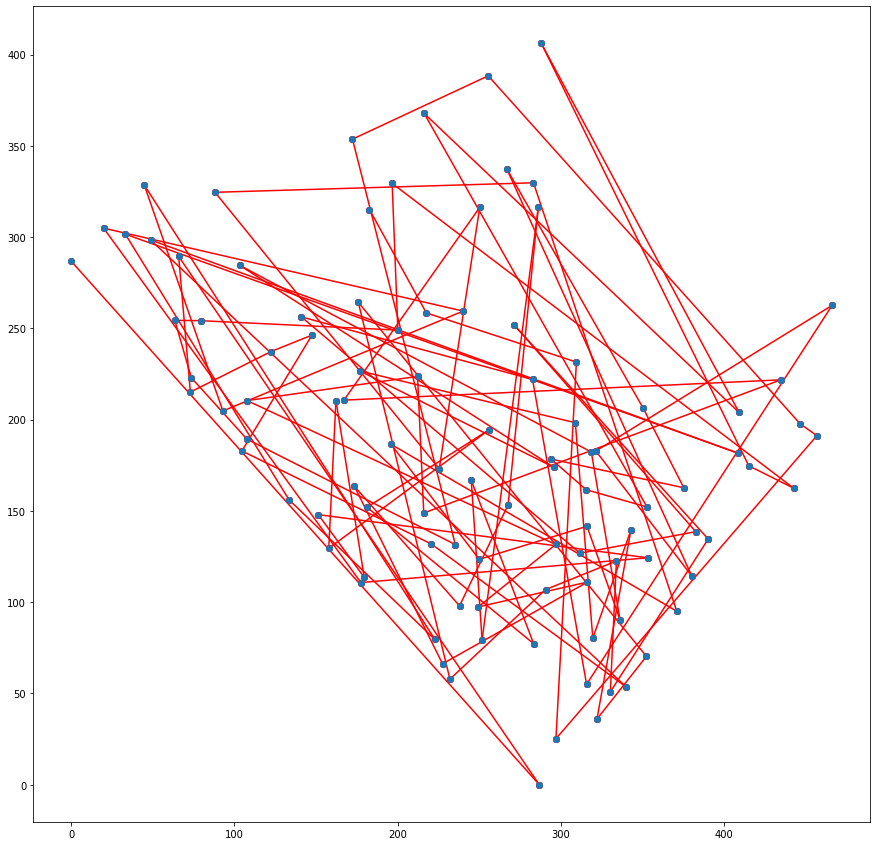

In [124]:
#lenghts of each trial
from cmath import nan
from numpy import NaN, size

index = [0, 118, 88, 100, 98, 109, 78, 121, 76, 113, 97, 112, 118]

choosen_plot_cnt = 1

for trial in range(1,len(index)):
    
    index[trial] = index[trial] + index[trial-1]
    dat_tr = mat_load[index[trial-1] : index[trial]+1, :, :, 0, :, :]
    pos_tr = roi_load[index[trial-1] : index[trial]+1, :, :, :]

    #choose state
    dat_stan = dat_tr[:, 0, :, :, :]
    dat_staw = dat_tr[:, 1, :, :, :]
    pos_stan = pos_tr[:, :, 0, :]
    pos_staw = pos_tr[:, :, 1, :]
    
    for sesion in range(4):

        #choose session
        dat_sean = dat_stan[:, sesion, :, :]
        dat_seaw = dat_staw[:, sesion, :, :]
        pos_sean = pos_stan[:, :, sesion]
        pos_seaw = pos_staw[:, :, sesion]

        #make dict to convert to dataframe
        dat_dict_an = {}
        dat_dict_aw = {}

        for matrix in range(np.shape(dat_sean)[0]):
            dat_dict_an[matrix] = dat_sean[matrix].flatten()
            dat_dict_aw[matrix] = dat_seaw[matrix].flatten()

        dat_df_an = pd.DataFrame(dat_dict_an, index=None).astype(float)
        dat_df_aw = pd.DataFrame(dat_dict_aw, index=None).astype(float)

        #exclude the rows/columns which index is not in the other dataframe
        df_corr_an = dat_df_an.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)
        df_corr_aw = dat_df_aw.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)

        #for activity correlation
        mask = df_corr_aw.index.isin(df_corr_an.index)
        df_corr_aw = df_corr_aw.loc[mask]
        mask = df_corr_an.index.isin(df_corr_aw.index)
        df_corr_an = df_corr_an.loc[mask]
        mask = []
        for x in df_corr_an.columns:
            if x not in df_corr_aw.columns:
                mask.append(x)
        df_corr_an = df_corr_an.drop(columns=mask)
        mask = []
        for x in df_corr_aw.columns:
            if x not in df_corr_an.columns:
                mask.append(x)
        df_corr_aw = df_corr_aw.drop(columns=mask)

        df_corr_an_pos = pd.DataFrame(index=df_corr_an.index, columns=df_corr_an.columns)
        df_corr_aw_pos = pd.DataFrame(index=df_corr_aw.index, columns=df_corr_aw.columns)
        
        for i in df_corr_an.index:
            for j in df_corr_an.columns:
                df_corr_an_pos.loc[i, j] = np.sqrt((pos_sean[i, 0]-pos_sean[j,0])**2 + (pos_sean[i, 1]-pos_sean[j,1])**2)
                df_corr_aw_pos.loc[i, j] = np.sqrt((pos_seaw[i, 0]-pos_seaw[j,0])**2 + (pos_seaw[i, 1]-pos_seaw[j,1])**2)

        df_an_pos = pd.DataFrame(df_corr_an_pos, index=None).astype(float)
        df_aw_pos = pd.DataFrame(df_corr_aw_pos, index=None).astype(float)
        df_corr_an_pos = df_an_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)
        df_corr_aw_pos = df_aw_pos.corr().dropna(how='all', axis=1).dropna(how='all', axis=0)
 
        links = df_corr_an.stack()
        links = links.reset_index()
        links.columns = ["var1", "var2", "value"]
        G=nx.from_pandas_edgelist(links, source="var1", target="var2", create_using=nx.MultiDiGraph)

        x_coor = df_an_pos[0]
        y_coor = df_an_pos[1]
        plt.figure(figsize=(15,15))
        for i in range(0, len(y_coor), 1):
            plt.plot(x_coor[i:i+2], y_coor[i:i+2], 'ro-')
        plt.plot(df_an_pos[0], df_an_pos[1], 'o')
        
        break    
    break

In [142]:
import plotly.graph_objects as go
import networkx as nx
from pyparsing import null_debug_action
warnings.filterwarnings('ignore')

links = df_corr_an.stack()
links = links.reset_index()
links.columns = ["var1", "var2", "value"]
links.loc[:, "x0"] = [0 for i in range(len(links))]
links.loc[:, "y0"] = [0 for i in range(len(links))]
links.loc[:, "x1"] = [0 for i in range(len(links))]
links.loc[:, "y1"] = [0 for i in range(len(links))]

for i in range(len(links['x1'])):
    links['x0'][i] = x_coor[int(links['var1'][i])]
    links['x1'][i] = x_coor[int(links['var2'][i])]
    links['y0'][i] = y_coor[int(links['var1'][i])]
    links['y1'][i] = y_coor[int(links['var2'][i])]

print(links)


       var1  var2     value          x0          y0          x1          y1
0         0     0  1.000000    0.000000  286.749916    0.000000  286.749916
1         0     1  0.179069    0.000000  286.749916  286.749916    0.000000
2         0     2  0.369225    0.000000  286.749916   65.798706  289.414531
3         0     3  0.447458    0.000000  286.749916   72.980725  215.108163
4         0     4  0.300101    0.000000  286.749916  122.155956  237.214397
...     ...   ...       ...         ...         ...         ...         ...
10196   118   112  0.060023  182.700784  315.044680  456.775740  191.226277
10197   118   113  0.049402  182.700784  315.044680  296.907608   25.177392
10198   118   115  0.117700  182.700784  315.044680  309.457006  231.513672
10199   118   116 -0.013001  182.700784  315.044680  217.514722  258.465808
10200   118   118  1.000000  182.700784  315.044680  182.700784  315.044680

[10201 rows x 7 columns]


In [189]:
import plotly.graph_objects as go

import networkx as nx

G=nx.from_pandas_edgelist(links, source="var1", target="var2", edge_attr=True)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.edges[edge]['x0'], G.edges[edge]['y0']
    x1, y1 = G.edges[edge]['x1'], G.edges[edge]['y1']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

nodes = links[["var1", "var2", "value","x0","y0","x1","y1"]]
print(nodes.set_index('x0')['var1'].to_dict())


attr_dict = nodes.set_index('x0')['var1'].to_dict()
nx.set_node_attributes(G, attr_dict, 'x0')
attr_dict = nodes.set_index('y0')['var1'].to_dict()
nx.set_node_attributes(G, attr_dict, 'y0')
HOVER_TOOLTIPS = [
        ("x", "@x"),
        ("y", "@y")
]
adjusted_node_size = dict([(node, 10) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
size_by_this_attribute = 'adjusted_node_size'

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1), width=1300, height=800)

#Create a network graph object

network_graph = from_networkx(G, nx.spring_layout(G, iterations=40), scale=1, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

output_notebook()

plot.renderers.append(network_graph)
show(plot)


{0.0: 0, 286.7499159875115: 1, 65.79870565580188: 2, 72.98072485927383: 3, 122.15595605608318: 4, 147.46005043984027: 5, 104.54323268576157: 6, 220.64618002798875: 7, 339.8944649018943: 8, 48.62692308067509: 9, 408.4322996148715: 10, 33.118517877553046: 11, 133.43135163900567: 12, 222.73645219042177: 13, 44.71292985867175: 14, 92.90574803043876: 15, 240.05192082402053: 16, 19.815810632122965: 18, 177.44112359716144: 19, 353.12291442539515: 20, 151.32184996713528: 21, 179.48465853411446: 22, 162.15485993424966: 23, 157.75225894216575: 24, 255.88633249230162: 25, 181.15834604759937: 26, 283.26285149495277: 27, 245.04543914612563: 28, 251.68378648354218: 29, 286.1780470954075: 30, 267.6022208192191: 31, 237.85590995349943: 32, 173.48324971003746: 33, 227.44581749544705: 34, 316.1995403934951: 35, 249.3209240496637: 36, 296.7391032657954: 37, 107.70879788997753: 38, 212.14141424751057: 39, 215.94722471024915: 40, 434.6245197608641: 41, 167.04394096041867: 42, 250.2609869003419: 43, 225.411

Loading BokehJS ...